# Submission Information:

### Team Member 1:
* UNI:  WL2522
* Name: Wilson Lui

### Team Member 2 [optional]:
* UNI:  
* Name:

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [59]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, scale, OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, f_classif
from sklearn.svm import LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

data = pd.read_csv('data.csv')


In [3]:
#Separate the ID column from the holdout set


holdout = pd.read_csv('data/holdout.csv')
ID = holdout['ID']
holdout = holdout.drop('ID', 1)


#Remove the "duration" feature to avoid getting overoptimistic results


data = data.drop('duration', 1)
holdout = holdout.drop('duration', 1)


In [4]:
#Convert the "month" and "day_of_week" features to integers
#(in order to experiment with treating them as both categorical and continuous features)


months = [('mar', 3), ('apr', 4), ('may', 5), ('jun', 6), ('jul', 7), ('aug', 8),
          ('sep', 9), ('oct', 10), ('nov', 11), ('dec', 12)]
weekdays = [('mon', 1), ('tue', 2), ('wed', 3), ('thu', 4), ('fri', 5)]

for month in months:
    data['month'].replace(to_replace=month[0], value=month[1], inplace=True)
    holdout['month'].replace(to_replace=month[0], value=month[1], inplace=True)
    
for day in weekdays:
    data['day_of_week'].replace(to_replace=day[0], value=day[1], inplace=True)
    holdout['day_of_week'].replace(to_replace=day[0], value=day[1], inplace=True)
    

In [5]:
#Create a copy of the dataset for encoding purposes and leave the original for visualizations
#Separate the categorical features from the numerical ones
#Encode category and response variable strings to integers
#Treat "prev_days" as a categorical variable due to the large majority of 999 values


num = ['age', 'month', 'day_of_week', 'campaign', 'prev_days', 'prev_contacts','emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

cat = ['job', 'marital_status', 'education', 'credit_default', 'housing',
       'loan', 'contact', 'prev_outcomes']


enc_data = data.copy()
enc_holdout = holdout.copy()

le = LabelEncoder()


for col in cat:
    levels = np.concatenate((enc_data[col].unique(), enc_holdout[col].unique()))
    le.fit(levels)
    enc_data[col] = le.transform(enc_data[col])
    enc_holdout[col] = le.transform(enc_holdout[col])


In [6]:
#Encode the response variable
#Separate the features from the response variable


levels = enc_data['subscribed'].unique()
le.fit(levels)
enc_data['subscribed'] = le.transform(enc_data['subscribed'])

X = enc_data.iloc[:,:-1]
y = enc_data.iloc[:,-1]


In [7]:
#Balance the dataset using Random Undersampling, SMOTE, and SMOTE + Edited Nearest Neighbors
#Create a different train/test split for each balanced dataset


rus = RandomUnderSampler(replacement=True)
sm = SMOTE()
enn = SMOTEENN()

X_rus, y_rus = rus.fit_sample(X, y)
X_sm, y_sm = sm.fit_sample(X, y)
X_enn, y_enn = enn.fit_sample(X, y)

X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, stratify=y_rus)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, stratify=y_sm)
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_enn, y_enn, stratify=y_enn)


# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

In [8]:
#Get summary statistics on the data


data.describe()

,age,month,day_of_week,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.019059,6.609317,2.982155,2.641639,961.537906,0.174385,0.080115,93.583705,-40.496740,3.618901,5166.932832
std,10.850807,2.042670,1.408273,2.803230,189.209917,0.498989,1.573180,1.162662,4.645301,1.737149,72.439480
min,17.000000,3.000000,1.000000,1.000000,0.000000,0.000000,-3.695294,88.311974,-52.220779,0.325461,4963.600000
25%,32.000000,5.000000,2.000000,1.000000,999.000000,0.000000,-1.724208,92.800661,-43.087110,1.377065,5101.000000
50%,38.000000,6.000000,3.000000,2.000000,999.000000,0.000000,1.085053,93.586959,-41.685507,4.800570,5194.000000
75%,47.000000,8.000000,4.000000,3.000000,999.000000,0.000000,1.366367,94.381404,-36.404580,4.943674,5226.000000
max,97.000000,12.000000,5.000000,56.000000,999.000000,7.000000,1.785673,98.263042,-25.323735,5.362403,5249.000000


Counter({'admin.': 8342, 'blue-collar': 7408, 'technician': 5371, 'services': 3168, 'management': 2340, 'retired': 1390, 'entrepreneur': 1198, 'self-employed': 1140, 'housemaid': 827, 'unemployed': 797, 'student': 708, 'unknown': 261})


([<matplotlib.axis.XTick at 0x14e04870eb8>,
 <a list of 12 Text xticklabel objects>)

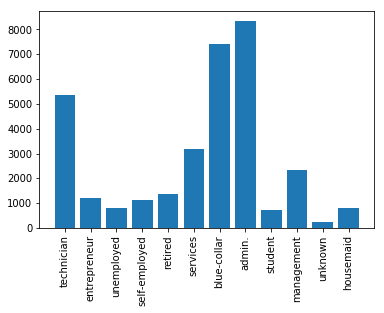

In [9]:
#Examine the distribution of job categories


job_count = Counter(data['job'])
print(job_count)
plt.bar(range(len(job_count)), job_count.values(), align='center')
plt.xticks(range(len(job_count)), list(job_count.keys()), rotation='vertical')


Counter({'married': 19955, 'single': 9256, 'divorced': 3676, 'unknown': 63})


([<matplotlib.axis.XTick at 0x14e076cf048>,
 <a list of 4 Text xticklabel objects>)

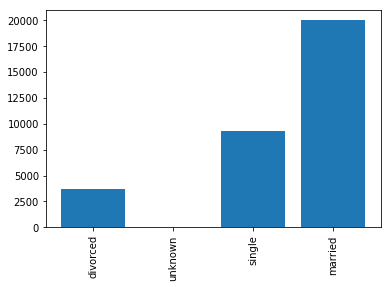

In [10]:
#Examine the distribution of marital statuses


marital_count = Counter(data['marital_status'])
print(marital_count)
plt.bar(range(len(marital_count)), marital_count.values(), align='center')
plt.xticks(range(len(marital_count)), list(marital_count.keys()), rotation='vertical')


Counter({'university.degree': 9760, 'high.school': 7580, 'basic.9y': 4889, 'professional.course': 4154, 'basic.4y': 3313, 'basic.6y': 1846, 'unknown': 1394, 'illiterate': 14})


([<matplotlib.axis.XTick at 0x14e047cb6d8>,
 <a list of 8 Text xticklabel objects>)

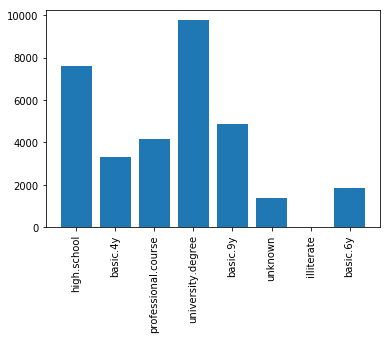

In [11]:
#Examine the distribution of education levels


education_count = Counter(data['education'])
print(education_count)
plt.bar(range(len(education_count)), education_count.values(), align='center')
plt.xticks(range(len(education_count)), list(education_count.keys()), rotation='vertical')


Counter({5: 11016, 7: 5716, 8: 4954, 6: 4272, 11: 3299, 4: 2097, 10: 540, 9: 465, 3: 437, 12: 154})


([<matplotlib.axis.XTick at 0x14e079b0128>,
 <a list of 10 Text xticklabel objects>)

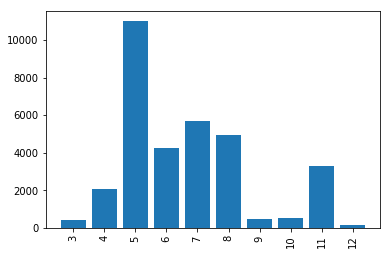

In [12]:
#Examine the distribution of call months


month_count = Counter(enc_data['month'])
print(month_count)
plt.bar(range(len(month_count)), month_count.values(), align='center')
plt.xticks(range(len(month_count)), list(month_count.keys()), rotation='vertical')


Counter({4: 6945, 1: 6749, 3: 6531, 2: 6495, 5: 6230})


([<matplotlib.axis.XTick at 0x14e0527b5c0>,
 <a list of 5 Text xticklabel objects>)

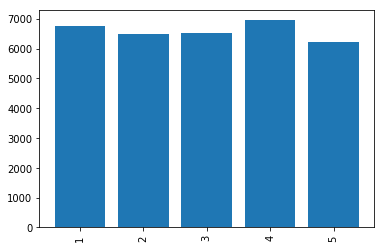

In [13]:
#Examine the distribution of days of the week


week_count = Counter(enc_data['day_of_week'])
print(week_count)
plt.bar(range(len(week_count)), week_count.values(), align='center')
plt.xticks(range(len(week_count)), list(week_count.keys()), rotation='vertical')


Counter({999: 31707, 3: 373, 6: 332, 4: 105, 9: 55, 7: 48, 2: 46, 12: 45, 5: 42, 10: 40, 13: 26, 11: 23, 1: 19, 15: 18, 14: 17, 8: 13, 0: 11, 16: 10, 17: 5, 18: 4, 19: 3, 22: 3, 21: 2, 20: 1, 26: 1, 27: 1})


([<matplotlib.axis.XTick at 0x14e07ac0eb8>,
 <a list of 26 Text xticklabel objects>)

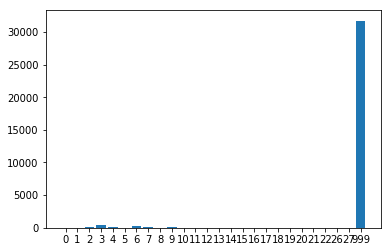

In [14]:
#Examine the distribution of previous days since last contact


days_count = Counter(data['prev_days'])
print(days_count)
plt.bar(range(len(days_count)), days_count.values(), align='center')
plt.xticks(range(len(days_count)), list(days_count.keys()))


Counter({'no': 26059, 'unknown': 6888, 'yes': 3})
Counter({'yes': 17176, 'no': 14974, 'unknown': 800})
Counter({'no': 27179, 'yes': 4971, 'unknown': 800})
Counter({'cellular': 20902, 'telephone': 12048})


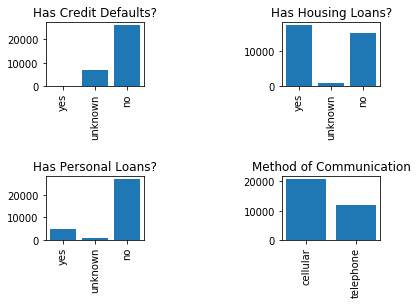

In [15]:
#Examine distribution of binary variables


default_count = Counter(data['credit_default'])
housing_count = Counter(data['housing'])
loan_count = Counter(data['loan'])
contact_count = Counter(data['contact'])
print(default_count)
print(housing_count)
print(loan_count)
print(contact_count)

ax1 = plt.subplot('331')
plt.bar(range(len(default_count)), default_count.values(), align='center')
plt.xticks(range(len(default_count)), list(default_count.keys()), rotation='vertical')
ax1.set_title('Has Credit Defaults?')

ax2 = plt.subplot('333')
plt.bar(range(len(housing_count)), housing_count.values(), align='center')
plt.xticks(range(len(housing_count)), list(housing_count.keys()), rotation='vertical')
ax2.set_title('Has Housing Loans?')

ax3 = plt.subplot('337')
plt.bar(range(len(loan_count)), loan_count.values(), align='center')
plt.xticks(range(len(loan_count)), list(loan_count.keys()), rotation='vertical')
ax3.set_title('Has Personal Loans?')

ax4 = plt.subplot('339')
plt.bar(range(len(contact_count)), contact_count.values(), align='center')
plt.xticks(range(len(contact_count)), list(contact_count), rotation='vertical')
ax4.set_title('Method of Communication')


Correlation Matrix
(nr_employed, euribor3m, emp_var_rate)


array([[ 1.        ,  0.9418152 ,  0.90294658],
       [ 0.9418152 ,  1.        ,  0.96852127],
       [ 0.90294658,  0.96852127,  1.        ]])

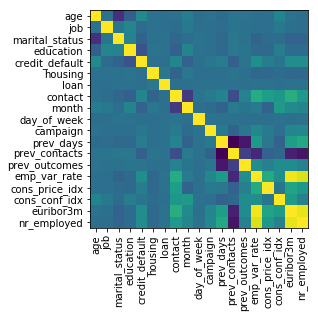

In [16]:
#Create covariance matrix heatmap to check for correlated features


cov = np.cov(scale(X), rowvar = False)
plt.imshow(cov, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(list(X))), list(X), rotation = 'vertical')
plt.yticks(range(len(list(X))), list(X))


#Take a closer look at the three continuous variables with high covariance


print('Correlation Matrix')
print('(nr_employed, euribor3m, emp_var_rate)')

np.corrcoef(np.stack((data['nr_employed'], data['euribor3m']), axis=0), data['emp_var_rate'])


# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [17]:
#Determine feature importance with RFE using SVMs


svc = LinearSVC()
svc_rfe = RFE(svc, n_features_to_select = 10)

sm = svc_rfe.fit(X_train_sm, y_train_sm)
print('sm :', sm.ranking_)

rus = svc_rfe.fit(X_train_rus, y_train_rus)
print('rus:', rus.ranking_)

enn = svc_rfe.fit(X_train_enn, y_train_enn)
print('enn:', enn.ranking_)


sm : [ 9  7  1  4  1  6  1  1  3  2  1 10  1  1  5  1  1  1  8]
rus: [ 8  3  1  5  1  1  9  1  1  1  6 10  1  1  1  2  4  1  7]
enn: [ 9  7  1  1  1  5  1  1  1  4  1 10  1  1  2  3  6  1  8]


In [18]:
#Determine feature importance with RFE using Logistic Regression


lr = LogisticRegression(n_jobs=8)
lr_rfe = RFE(lr, n_features_to_select = 10)

sm_lr = lr_rfe.fit(X_train_sm, y_train_sm)
rus_lr = lr_rfe.fit(X_train_rus, y_train_rus)
enn_lr = lr_rfe.fit(X_train_enn, y_train_enn)

print('sm :', sm_lr.ranking_)
print('rus:', rus_lr.ranking_)
print('enn:', enn_lr.ranking_)


sm : [ 8  7  1  3  1  6  1  1  4  2  1 10  1  1  5  1  1  1  9]
rus: [ 8  7  1  3  1  6  1  1  4  2  1 10  1  1  5  1  1  1  9]
enn: [ 8  7  1  3  1  6  1  1  4  2  1 10  1  1  5  1  1  1  9]


In [19]:
#Determine feature importance with F-scores, mutual information, and SelectKBest


f = SelectKBest(f_classif, k=10)
mi = SelectKBest(mutual_info_classif, k=10)
                
f.fit(X_train_sm, y_train_sm)
mi.fit(X_train_sm, y_train_sm)

print('f :', f.get_support())
print('mi:', mi.get_support())


f : [False False False False  True False False  True False False  True  True
  True  True  True  True False  True  True]
mi: [ True  True  True  True False  True False False  True  True  True False
 False False False False False  True  True]


In [20]:
#Determine feature importance with stability selection using Logistic Regression


from sklearn.linear_model import RandomizedLogisticRegression

rlr = RandomizedLogisticRegression()

rus_rlr = rlr.fit(X_train_rus, y_train_rus)
sm_rlr = rlr.fit(X_train_sm, y_train_sm)
enn_rlr = rlr.fit(X_train_enn, y_train_enn)

print('sm :', sm_rlr.scores_)
print('rus:', rus_rlr.scores_)
print('enn:', enn_rlr.scores_)


sm : [ 0.02   0.085  0.545  0.985  1.     0.025  0.49   1.     0.445  0.535  1.
  0.87   0.145  1.     0.615  0.115  0.98   0.175  1.   ]
rus: [ 0.02   0.085  0.545  0.985  1.     0.025  0.49   1.     0.445  0.535  1.
  0.87   0.145  1.     0.615  0.115  0.98   0.175  1.   ]
enn: [ 0.02   0.085  0.545  0.985  1.     0.025  0.49   1.     0.445  0.535  1.
  0.87   0.145  1.     0.615  0.115  0.98   0.175  1.   ]


In [21]:
#Drop the features deemed to be unimportant: "age", "housing", "nr_employed"
#Perform One Hot Encoding on the categorical features
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 5, 18]
leftover_discrete = np.array([0, 1, 2, 3, 4, 5, 11])
levels = np.array([12, 4, 8, 3, 3, 2, 3])

one = OneHotEncoder(categorical_features=leftover_discrete, n_values=levels)

X_train_rus_enc = one.fit_transform(np.delete(X_train_rus, dropped, axis=1))
X_train_sm_enc = one.fit_transform(np.delete(X_train_sm, dropped, axis=1))
X_train_enn_enc = one.fit_transform(np.delete(X_train_enn, dropped, axis=1))

pipe = make_pipeline(MaxAbsScaler(), LogisticRegressionCV())

rus_score = cross_val_score(pipe, X_train_rus_enc, y_train_rus, cv=10, scoring='roc_auc')
print('rus:', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm_enc, y_train_sm, cv=10, scoring='roc_auc')
print('sm :', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn_enc, y_train_enn, cv=10, scoring='roc_auc')
print('enn:', np.mean(enn_score))
    

rus: 0.773373700693
sm : 0.858581888274
enn: 0.863075782424


In [22]:
#Drop the features deemed to be unimportant: "age", "job", "housing", "nr_employed"
#Perform One Hot Encoding on the categorical features
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 1, 5, 18]
leftover_discrete = [0, 1, 2, 3, 4, 10]
levels = np.array([4, 8, 3, 3, 2, 3])

one = OneHotEncoder(categorical_features=leftover_discrete, n_values=levels)

X_train_rus_enc = one.fit_transform(np.delete(X_train_rus, dropped, axis=1))
X_train_sm_enc = one.fit_transform(np.delete(X_train_sm, dropped, axis=1))
X_train_enn_enc = one.fit_transform(np.delete(X_train_enn, dropped, axis=1))

pipe = make_pipeline(MaxAbsScaler(), LogisticRegressionCV())

rus_score = cross_val_score(pipe, X_train_rus_enc, y_train_rus, cv=10, scoring='roc_auc')
print('rus:', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm_enc, y_train_sm, cv=10, scoring='roc_auc')
print('sm :', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn_enc, y_train_enn, cv=10, scoring='roc_auc')
print('enn:', np.mean(enn_score))
    

rus: 0.771173646579
sm : 0.84986389861
enn: 0.853901625887


In [23]:
#Drop the features deemed to be unimportant: "age", "job", "housing", "cons_price_idx", "nr_employed"
#Perform One Hot Encoding on the categorical features
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 10]
levels = np.array([4, 8, 3, 3, 2, 3])

one = OneHotEncoder(categorical_features=leftover_discrete, n_values=levels)

X_train_rus_enc = one.fit_transform(np.delete(X_train_rus, dropped, axis=1))
X_train_sm_enc = one.fit_transform(np.delete(X_train_sm, dropped, axis=1))
X_train_enn_enc = one.fit_transform(np.delete(X_train_enn, dropped, axis=1))

pipe = make_pipeline(MaxAbsScaler(), LogisticRegressionCV())

rus_score = cross_val_score(pipe, X_train_rus_enc, y_train_rus, cv=10, scoring='roc_auc')
print('rus:', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm_enc, y_train_sm, cv=10, scoring='roc_auc')
print('sm :', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn_enc, y_train_enn, cv=10, scoring='roc_auc')
print('enn:', np.mean(enn_score))


rus: 0.771430987975
sm : 0.848548775629
enn: 0.853016719277


In [24]:
#Drop the features deemed to be unimportant: "age", "job", "housing", "prev_days", "cons_price_idx", "nr_employed"
#Perform One Hot Encoding on the categorical features
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 1, 5, 11, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 9]
levels = np.array([4, 8, 3, 3, 2, 3])

one = OneHotEncoder(categorical_features=leftover_discrete, n_values=levels)

X_train_rus_enc = one.fit_transform(np.delete(X_train_rus, dropped, axis=1))
X_train_sm_enc = one.fit_transform(np.delete(X_train_sm, dropped, axis=1))
X_train_enn_enc = one.fit_transform(np.delete(X_train_enn, dropped, axis=1))

pipe = make_pipeline(MaxAbsScaler(), LogisticRegressionCV())

rus_score = cross_val_score(pipe, X_train_rus_enc, y_train_rus, cv=10, scoring='roc_auc')
print('rus:', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm_enc, y_train_sm, cv=10, scoring='roc_auc')
print('sm :', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn_enc, y_train_enn, cv=10, scoring='roc_auc')
print('enn:', np.mean(enn_score))


rus: 0.771346847873
sm : 0.845069368408
enn: 0.849921795219


In [25]:
#Score the Logistic Regression model that produced the best results on the training data
#Drop the "age", "job", "housing", "cons_price_idx", and "nr_employed" features


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 10]
levels = np.array([4, 8, 3, 3, 2, 3])

one = OneHotEncoder(categorical_features=leftover_discrete, n_values=levels)

X_train_rus_enc = one.fit_transform(np.delete(X_train_rus, dropped, axis=1))
X_train_sm_enc = one.fit_transform(np.delete(X_train_sm, dropped, axis=1))
X_train_enn_enc = one.fit_transform(np.delete(X_train_enn, dropped, axis=1))

X_test_rus_enc = one.fit_transform(np.delete(X_test_rus, dropped, axis=1))
X_test_sm_enc = one.fit_transform(np.delete(X_test_sm, dropped, axis=1))
X_test_enn_enc = one.fit_transform(np.delete(X_test_enn, dropped, axis=1))

pipe = make_pipeline(MaxAbsScaler(), LogisticRegressionCV(cv=10, scoring='roc_auc'))

rus_lr = pipe.fit(X_train_rus_enc, y_train_rus)
print('rus:', rus_lr.score(X_test_rus_enc, y_test_rus))

sm_lr = pipe.fit(X_train_sm_enc, y_train_sm)
print('sm :', sm_lr.score(X_test_sm_enc, y_test_sm))

enn_lr = pipe.fit(X_train_enn_enc, y_train_enn)
print('enn:', enn_lr.score(X_test_enn_enc, y_test_enn))


rus: 0.716056034483
sm : 0.77050413845
enn: 0.76792518185


In [26]:
#Determine the best resampling technique to use with SGDClassifier and the chosen feature set


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 10]
levels = np.array([4, 8, 3, 3, 2, 3])

one = OneHotEncoder(categorical_features=leftover_discrete, n_values=levels)

X_train_rus_enc = one.fit_transform(np.delete(X_train_rus, dropped, axis=1))
X_train_sm_enc = one.fit_transform(np.delete(X_train_sm, dropped, axis=1))
X_train_enn_enc = one.fit_transform(np.delete(X_train_enn, dropped, axis=1))

grid = {'alpha': np.logspace(-1,7, 9)}

methods = [('rus', X_train_rus, y_train_rus), ('sm ', X_train_sm, y_train_sm), ('enn', X_train_enn, y_train_enn)]
scaler = MaxAbsScaler()

for array in methods:
    gridsearch = GridSearchCV(SGDClassifier(loss='modified_huber', n_iter=np.ceil(10**6/np.shape(array[1])[0])),
                                     param_grid=grid, scoring='roc_auc', cv=15)
    
    sgd = gridsearch.fit(scaler.fit_transform(array[1]), array[2])
    print(array[0], 'best score:', sgd.score(array[1], array[2]))
    print(array[0], 'best parameters:', sgd.best_params_)
    

rus best score: 0.756829615454
rus best parameters: {'alpha': 0.10000000000000001}
sm  best score: 0.760826530828
sm  best parameters: {'alpha': 0.10000000000000001}
enn best score: 0.765326143096
enn best parameters: {'alpha': 0.10000000000000001}


In [27]:
#Score the SGDClassifier model with the optimal parameter value and the chosen feature set


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 10]
levels = np.array([4, 8, 3, 3, 2, 3])

one = OneHotEncoder(categorical_features=leftover_discrete, n_values=levels)

X_train_rus_enc = one.fit_transform(np.delete(X_train_rus, dropped, axis=1))
X_train_sm_enc = one.fit_transform(np.delete(X_train_sm, dropped, axis=1))
X_train_enn_enc = one.fit_transform(np.delete(X_train_enn, dropped, axis=1))

X_test_rus_enc = one.fit_transform(np.delete(X_test_rus, dropped, axis=1))
X_test_sm_enc = one.fit_transform(np.delete(X_test_sm, dropped, axis=1))
X_test_enn_enc = one.fit_transform(np.delete(X_test_enn, dropped, axis=1))

sgd_pipe = make_pipeline(MaxAbsScaler(),
                         SGDClassifier(alpha=0.1,loss='modified_huber',n_iter=np.ceil(10**6/np.shape(X_train_enn_enc)[0])))

rus_sgd = sgd_pipe.fit(X_train_rus_enc, y_train_rus)
print('rus:', roc_auc_score(rus_sgd.predict(X_test_rus_enc), y_test_rus))

sm_sgd = sgd_pipe.fit(X_train_sm_enc, y_train_sm)
print('sm :', roc_auc_score(sm_sgd.predict(X_test_sm_enc), y_test_sm))

enn_sgd = sgd_pipe.fit(X_train_enn_enc, y_train_enn)
print('enn:', roc_auc_score(enn_sgd.predict(X_test_enn_enc), y_test_enn))


rus: 0.716056285366
sm : 0.754442039213
enn: 0.755210003859


# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [28]:
#Perform a grid search to find the optimal Decision Tree parameter values for max_depth and max_features


grid = {'max_features': range(3, 15, 1), 'max_depth': np.linspace(5, 50, 2)}

search = GridSearchCV(DecisionTreeClassifier(), param_grid = grid, scoring='roc_auc', cv=10)

rus = search.fit(X_train_rus, y_train_rus)
sm = search.fit(X_train_sm, y_train_sm)
enn = search.fit(X_train_enn, y_train_enn)

print('rus:', rus.score(X_train_rus, y_train_rus))
print(rus.best_params_)
print('sm :', sm.score(X_train_sm, y_train_sm))
print(sm.best_params_)
print('enn:', enn.score(X_train_enn, y_train_enn))
print(enn.best_params_)


rus: 0.907507183908
{'max_depth': 50.0, 'max_features': 7}
sm : 0.962354653269
{'max_depth': 50.0, 'max_features': 7}
enn: 1.0
{'max_depth': 50.0, 'max_features': 7}


In [29]:
#Perform cross-validation using each balanced dataset and the optimal parameter values


dt = DecisionTreeClassifier(max_features=11, max_depth=50)

print('rus:', np.mean(cross_val_score(dt, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')))
print('sm :', np.mean(cross_val_score(dt, X_train_sm, y_train_sm, cv=10, scoring='roc_auc')))
print('enn:', np.mean(cross_val_score(dt, X_train_enn, y_train_enn, cv=10, scoring='roc_auc')))


rus: 0.646907635182
sm : 0.894361465729
enn: 0.897480344981


In [30]:
#Score the test set using the chosen parameters values


rus_dt = dt.fit(X_train_rus, y_train_rus)
sm_dt = dt.fit(X_train_sm, y_train_sm)
enn_dt = dt.fit(X_train_enn, y_train_enn)

print('rus:', roc_auc_score(rus_dt.predict(X_test_rus), y_test_rus))
print('sm:', roc_auc_score(sm_dt.predict(X_test_sm), y_test_sm))
print('enn:', roc_auc_score(enn_dt.predict(X_test_enn), y_test_enn))


rus: 0.916016670151
sm: 0.964235701966
enn: 0.901675088316


In [54]:
#Perform a grid search to find the optimal Random Forest parameter value for max_depth


grid = {'max_depth': np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None])}
search = GridSearchCV(RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs=8),
                      param_grid = grid, scoring='roc_auc', cv=10)


rus_rt = search.fit(X_train_rus, y_train_rus)
sm_rt = search.fit(X_train_sm, y_train_sm)
enn_rt = search.fit(X_train_enn, y_train_enn)

print('rus:', rus_rt.score(X_train_rus, y_train_rus))
print(rus_rt.best_params_)
print('sm :', sm_rt.score(X_train_sm, y_train_sm))
print(sm_rt.best_params_)
print('enn:', enn_rt.score(X_train_enn, y_train_enn))
print(enn_rt.best_params_)


rus: 0.977190769401
{'max_depth': 45}
sm : 0.996651646065
{'max_depth': 45}
enn: 0.999999917868
{'max_depth': 45}


In [58]:
#Score the test set using the chosen parameter


rt = RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=45, n_jobs=8)

rus_rt = rt.fit(X_train_rus, y_train_rus)
sm_rt = rt.fit(X_train_sm, y_train_sm)
enn_rt = rt.fit(X_train_enn, y_train_enn)

print('rus:', roc_auc_score(rus_rt.predict(X_test_rus), y_test_rus))
print('sm:', roc_auc_score(sm_rt.predict(X_test_sm), y_test_sm))
print('enn:', roc_auc_score(enn_rt.predict(X_test_enn), y_test_enn))


rus: 0.927990049056
sm: 0.981833903977
enn: 0.943452806457


In [60]:
#Perform a grid search to find the optimal Extra Trees parameter value for max_depth


grid = {'max_depth': np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None])}
et_search = GridSearchCV(ExtraTreesClassifier(n_estimators=50, max_features='sqrt', n_jobs=8),
                      param_grid = grid, scoring='roc_auc', cv=10)


rus_et = search.fit(X_train_rus, y_train_rus)
sm_et = search.fit(X_train_sm, y_train_sm)
enn_et = search.fit(X_train_enn, y_train_enn)

print('rus:', rus_et.score(X_train_rus, y_train_rus))
print(rus_et.best_params_)
print('sm :', sm_et.score(X_train_sm, y_train_sm))
print(sm_et.best_params_)
print('enn:', enn_et.score(X_train_enn, y_train_enn))
print(enn_et.best_params_)


rus: 0.976415931761
{'max_depth': 50}
sm : 0.996551705149
{'max_depth': 50}
enn: 0.999999911468
{'max_depth': 50}


In [61]:
#Score the test set using the chosen parameter


et = ExtraTreesClassifier(n_estimators=50, max_features='sqrt', max_depth=50, n_jobs=8)

rus_et = et.fit(X_train_rus, y_train_rus)
sm_et = et.fit(X_train_sm, y_train_sm)
enn_et = et.fit(X_train_enn, y_train_enn)

print('rus:', roc_auc_score(rus_et.predict(X_test_rus), y_test_rus))
print('sm:', roc_auc_score(sm_et.predict(X_test_sm), y_test_sm))
print('enn:', roc_auc_score(enn_et.predict(X_test_enn), y_test_enn))

rus: 0.946005317179
sm: 0.983551291705
enn: 0.95608571333


# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [1]:
#write code below, you can make multiple cells
assert 5 + 5 == 10